# **Necessary imports**


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import copy
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from PIL import Image
from IPython.display import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# **Exploring the dataset**


In [2]:
columns = {'name': 'X', 'score': 'y'}
dataset = pd.read_csv("data/dataset.csv")
dataset.rename(columns=columns, inplace=True)

In [3]:
dataset.head()

,image,memorability_score
0,0002.jpg,0.708333
1,0003.jpg,0.703704
2,0004.jpg,0.703704
3,0008.jpg,0.700000
4,0005.jpg,0.680000


In [4]:
len(dataset)

1000

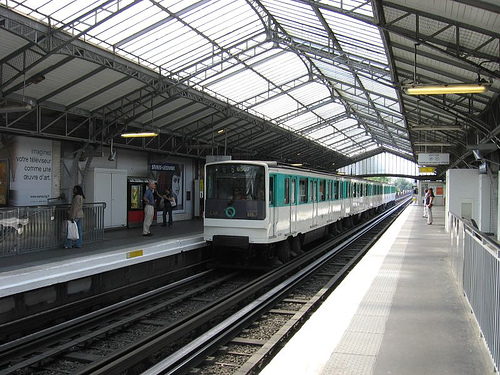

In [5]:
Image(filename="images/000981.jpg")

In [6]:
def split_csv(dataset):
    df = dataset
    split_percent = 0.85
    df_length = int(len(df)*split_percent)
    df1 = df.iloc[:df_length, :]
    df2 = df.iloc[df_length:, :]
    return df1, df2

In [7]:
dataset_train, dataset_validation = split_csv(dataset)

In [8]:
len(dataset_train), len(dataset_validation)

(850, 150)

In [9]:
dataset_train.to_csv("data/train.csv")

In [10]:
dataset_validation.to_csv("data/val.csv")

In [11]:
dataset_train

,image,memorability_score
0,0002.jpg,0.708333
1,0003.jpg,0.703704
2,0004.jpg,0.703704
3,0008.jpg,0.700000
4,0005.jpg,0.680000
...,...,...
845,000845.jpg,0.708333
846,000846.jpg,0.703704
847,000856.jpg,0.696970
848,000847.jpg,0.680000


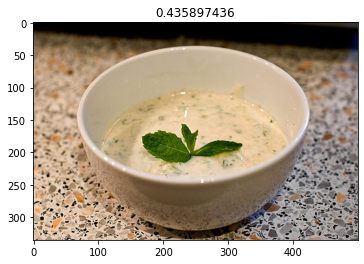

In [12]:
def show_sample_from_dataset(i=0):
    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))
    image_path = "images/"+str(dataset_train.iloc[i]["image"])
    mem_value = str(dataset_train.iloc[i]["memorability_score"])
    show_image(io.imread(image_path), mem_value)

show_sample_from_dataset(300)

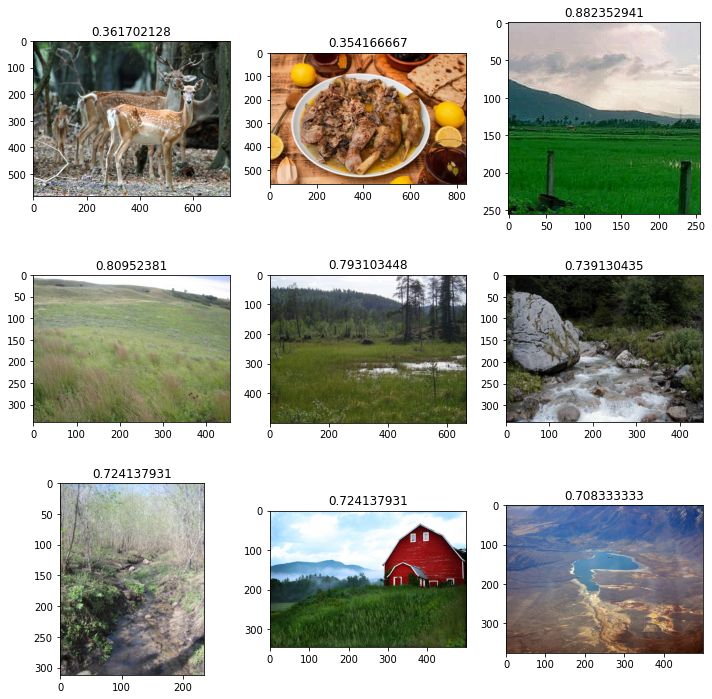

In [13]:
def show_grid(n_row, n_col):
    i = 500
    _, fig = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join(
            "images/"+str(dataset_train.iloc[i]["image"]))
        mem_value = os.path.join(
            str(dataset_train.iloc[i]["memorability_score"]))
        f.imshow(io.imread(image_path))
        f.title.set_text(str(mem_value))
        i = i+1

show_grid(3, 3)

# **Statistics**


In [14]:
dataset_train["memorability_score"].describe()

count    850.000000
mean       0.521978
std        0.093039
min        0.269231
25%        0.459459
50%        0.513514
75%        0.575758
max        0.913043
Name: memorability_score, dtype: float64

In [15]:
dataset_validation["memorability_score"].describe()

count    150.000000
mean       0.504780
std        0.076966
min        0.354167
25%        0.446948
50%        0.500000
75%        0.566667
max        0.678571
Name: memorability_score, dtype: float64

## **Data preprocessing**


In [16]:
class AsetheticsDataset(Dataset):
    '''asethitics dataset'''

    def __init__(self, dataframe, root_dir, transform=None):
        """
            Args:
                csv_file (string): Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(image_name)
        mem_val = self.data.iloc[idx, 1]
        return_sample = {
            'image': image,
            'memorability_score': mem_val
        }
        if self.transform:
            return_sample = self.transform(return_sample)

        return return_sample

In [17]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mem_val = sample['image'], sample["memorability_score"]
        h, w = image.shape[:2]
        img = transform.resize(image, (self.output_size, self.output_size, 3))
        return {'image': img, 'memorability_score': mem_val}


In [18]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mem_val = sample['image'], sample['memorability_score']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}

In [19]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        normalized = (image - self.mean) / self.std
        return {
            "image": normalized,
            "memorability_score": mem_val
        }

In [20]:
transformed_dataset_train = AsetheticsDataset(dataset_train, root_dir="images",
                                              transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                            ]))
transformed_dataset_val = AsetheticsDataset(dataset_validation, root_dir="images",
                                            transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                          ]))

In [21]:
train_dataloader = DataLoader(
    transformed_dataset_train, batch_size=128, shuffle=True)
validation_dataloader = DataLoader(
    transformed_dataset_val, batch_size=128, shuffle=True)

In [22]:
dataloaders = {
    "train": train_dataloader,
    "val": validation_dataloader
}

In [23]:
dataset_sizes = {
    "train": len(dataset_train),
    "val": len(dataset_validation)
}

# **ResNet50**


In [24]:
model_50 = models.resnet50("pth/resnet50-0676ba61.pth")

In [25]:
# model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
    param.requires_grad = False

n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

1


In [26]:
model_50 = model_50.double()
resmodel_50 = copy.deepcopy(model_50)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history = []
    orignal_model = None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):

                inputs = batched_data["image"]
                inputs = inputs.to(device)
                labels = batched_data["memorability_score"]
                labels = labels.view(-1, 1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ", loss.item())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                running_loss_history.append(epoch_loss)
            else:
                val_running_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < low_loss:

                print("saving best model......")
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "models/resnet50_weights.pt")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    original_model = copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model, original_model, running_loss_history, val_running_loss_history

In [29]:
epchocs_count = 100

In [30]:
best_model_50, model_50, running_loss_history, val_running_loss_history = train_model(
    model_50, criterion, optimizer, exp_lr_scheduler, epchocs_count)

Epoch 0/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:57,  9.56s/it]

  batch loss:     0.210098761538353


 29%|████████████████████████▎                                                            | 2/7 [00:18<00:45,  9.14s/it]

  batch loss:     0.15177298930881944


 43%|████████████████████████████████████▍                                                | 3/7 [00:28<00:37,  9.42s/it]

  batch loss:     0.11022028819577065


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:36<00:27,  9.15s/it]

  batch loss:     0.07796499974359455


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:45<00:18,  9.02s/it]

  batch loss:     0.04685654168634863


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:54<00:08,  8.99s/it]

  batch loss:     0.06113757846863718


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.61s/it]


  batch loss:     0.061225319444577805
train Loss: 0.1050


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.84s/it]

  batch loss:     0.058447153660447636


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.52s/it]


  batch loss:     0.07014372586121123
val Loss: 0.0602
saving best model......

Epoch 1/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:53,  8.96s/it]

  batch loss:     0.07569857346049301


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.63s/it]

  batch loss:     0.08370419872660402


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.47s/it]

  batch loss:     0.08400354878322755


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.33s/it]

  batch loss:     0.07701132257490534


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.27s/it]

  batch loss:     0.081584104821844


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.44s/it]

  batch loss:     0.06597543527251606


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.98s/it]


  batch loss:     0.08130453805382343
train Loss: 0.0783


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.85s/it]

  batch loss:     0.04986632953217876


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.59s/it]


  batch loss:     0.05278424142663695
val Loss: 0.0503
saving best model......

Epoch 2/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:58,  9.82s/it]

  batch loss:     0.0613817305358564


 29%|████████████████████████▎                                                            | 2/7 [00:20<00:50, 10.08s/it]

  batch loss:     0.04997662253429839


 43%|████████████████████████████████████▍                                                | 3/7 [00:28<00:37,  9.28s/it]

  batch loss:     0.06976670070370489


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:37<00:27,  9.03s/it]

  batch loss:     0.043894385525708464


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:45<00:17,  8.83s/it]

  batch loss:     0.047371591201998825


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:54<00:09,  9.02s/it]

  batch loss:     0.05515724707889076


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.64s/it]


  batch loss:     0.056051156930036136
train Loss: 0.0547


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:08<00:08,  8.17s/it]

  batch loss:     0.0643944192711461


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.75s/it]


  batch loss:     0.06729785262736022
val Loss: 0.0648

Epoch 3/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:52,  8.81s/it]

  batch loss:     0.046943769870671254


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:44,  8.82s/it]

  batch loss:     0.06626709008777219


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:35,  8.93s/it]

  batch loss:     0.05517093724414114


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.98s/it]

  batch loss:     0.05399472648643584


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.66s/it]

  batch loss:     0.06190530939031164


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:52<00:08,  8.61s/it]

  batch loss:     0.05028408165292615


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.22s/it]


  batch loss:     0.04948587660328176
train Loss: 0.0552


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.37s/it]

  batch loss:     0.04665532987143493


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.31s/it]


  batch loss:     0.03941635864730897
val Loss: 0.0456
saving best model......

Epoch 4/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:52,  8.70s/it]

  batch loss:     0.04477855017607914


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.73s/it]

  batch loss:     0.05415652357089085


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:35,  8.86s/it]

  batch loss:     0.041799439831205994


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.80s/it]

  batch loss:     0.042004479934393685


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.66s/it]

  batch loss:     0.03781971130104548


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:51<00:08,  8.55s/it]

  batch loss:     0.06480436876865432


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.16s/it]


  batch loss:     0.05687094397788896
train Loss: 0.0485


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.17s/it]

  batch loss:     0.043632886821944016


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.23s/it]


  batch loss:     0.0409752760170028
val Loss: 0.0432
saving best model......

Epoch 5/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.26s/it]

  batch loss:     0.04575112443004074


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.31s/it]

  batch loss:     0.047664587427648376


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.51s/it]

  batch loss:     0.04972502912268652


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.45s/it]

  batch loss:     0.04959072641965229


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.49s/it]

  batch loss:     0.03942393592167865


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.52s/it]

  batch loss:     0.047452647808198314


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.00s/it]


  batch loss:     0.03517017269014345
train Loss: 0.0455


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.16s/it]

  batch loss:     0.04201026653884954


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.22s/it]


  batch loss:     0.0457266069968768
val Loss: 0.0426
saving best model......

Epoch 6/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:55,  9.26s/it]

  batch loss:     0.042014460360393815


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.63s/it]

  batch loss:     0.04314215003517517


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:34,  8.66s/it]

  batch loss:     0.03636481521985516


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.64s/it]

  batch loss:     0.035489166052811195


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.60s/it]

  batch loss:     0.048792694630400556


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:51<00:08,  8.42s/it]

  batch loss:     0.048701485959278146


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.16s/it]


  batch loss:     0.0464762540347442
train Loss: 0.0428


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.20s/it]

  batch loss:     0.03886619929760228


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.24s/it]


  batch loss:     0.04997658085737842
val Loss: 0.0405
saving best model......

Epoch 7/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:52,  8.78s/it]

  batch loss:     0.0384888506910005


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.37s/it]

  batch loss:     0.036976940003582905


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.39s/it]

  batch loss:     0.05021803744818577


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.48s/it]

  batch loss:     0.03885619641950165


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.36s/it]

  batch loss:     0.04828405142236998


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.39s/it]

  batch loss:     0.03953877722015439


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.96s/it]


  batch loss:     0.031240194076219776
train Loss: 0.0410


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.24s/it]

  batch loss:     0.042583501448228256


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


  batch loss:     0.026611306697785806
val Loss: 0.0402
saving best model......

Epoch 8/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.32s/it]

  batch loss:     0.04083502234047224


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.32s/it]

  batch loss:     0.035968795281955186


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.43s/it]

  batch loss:     0.0343863010349726


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.53s/it]

  batch loss:     0.0451488895802218


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.49s/it]

  batch loss:     0.04186540454246083


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.49s/it]

  batch loss:     0.04672121424774439


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.02s/it]


  batch loss:     0.0435525534887236
train Loss: 0.0411


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.71s/it]

  batch loss:     0.03909666250072759


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.58s/it]


  batch loss:     0.04449932110308346
val Loss: 0.0399
saving best model......

Epoch 9/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:58,  9.69s/it]

  batch loss:     0.040849932488044124


 29%|████████████████████████▎                                                            | 2/7 [00:18<00:45,  9.17s/it]

  batch loss:     0.033600369909692146


 43%|████████████████████████████████████▍                                                | 3/7 [00:27<00:35,  8.94s/it]

  batch loss:     0.04204217323633583


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.86s/it]

  batch loss:     0.04243365407290327


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:44<00:17,  8.75s/it]

  batch loss:     0.0420490031883496


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:53<00:08,  8.96s/it]

  batch loss:     0.04305874640554211


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:59<00:00,  8.50s/it]


  batch loss:     0.04167987633788112
train Loss: 0.0408


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:09<00:09,  9.14s/it]

  batch loss:     0.04089532468437017


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.27s/it]

  batch loss:     0.032060928490674205
val Loss: 0.0396
saving best model......



Epoch 10/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:54,  9.01s/it]

  batch loss:     0.04641826033261972


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:44,  8.87s/it]

  batch loss:     0.03830185274626852


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:35,  8.99s/it]

  batch loss:     0.03765989421892378


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.87s/it]

  batch loss:     0.04066625135860787


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:44<00:17,  8.89s/it]

  batch loss:     0.03969447131554812


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:53<00:08,  8.83s/it]

  batch loss:     0.03638872921911118


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.40s/it]


  batch loss:     0.05191767587677872
train Loss: 0.0410


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:08<00:08,  8.34s/it]

  batch loss:     0.041494818055994954


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.87s/it]


  batch loss:     0.026848564448037734
val Loss: 0.0393
saving best model......

Epoch 11/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:59,  9.96s/it]

  batch loss:     0.04086078307056698


 29%|████████████████████████▎                                                            | 2/7 [00:18<00:46,  9.39s/it]

  batch loss:     0.041354747189376054


 43%|████████████████████████████████████▍                                                | 3/7 [00:27<00:36,  9.03s/it]

  batch loss:     0.03836020497198168


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:36<00:26,  8.96s/it]

  batch loss:     0.043610958762111636


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:45<00:17,  8.99s/it]

  batch loss:     0.04055375401504377


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:53<00:08,  8.80s/it]

  batch loss:     0.04055260405036429


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:59<00:00,  8.45s/it]


  batch loss:     0.04154984404495924
train Loss: 0.0409


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.28s/it]

  batch loss:     0.03798391375381637


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.28s/it]


  batch loss:     0.04590856332142656
val Loss: 0.0391
saving best model......

Epoch 12/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.15s/it]

  batch loss:     0.04858039920276649


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.08s/it]

  batch loss:     0.04331676454759275


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.09s/it]

  batch loss:     0.03299807760583428


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.15s/it]

  batch loss:     0.04154997337652049


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.07s/it]

  batch loss:     0.02995430177666824


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.22s/it]

  batch loss:     0.044971540769453686


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.74s/it]


  batch loss:     0.0430201203363891
train Loss: 0.0405


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.26s/it]

  batch loss:     0.03839653436451124


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


  batch loss:     0.04269286964554908
val Loss: 0.0390
saving best model......

Epoch 13/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.16s/it]

  batch loss:     0.0365741634850245


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.18s/it]

  batch loss:     0.041283405932199625


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.23s/it]

  batch loss:     0.04369009904144751


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.35s/it]

  batch loss:     0.03944422612062704


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.39s/it]

  batch loss:     0.03237408768087247


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.30s/it]

  batch loss:     0.04071987334786699


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.84s/it]


  batch loss:     0.050804848874381386
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.90s/it]

  batch loss:     0.03972300985677493


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.03387721925942866
val Loss: 0.0389
saving best model......

Epoch 14/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.01s/it]

  batch loss:     0.036713701619631764


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.03s/it]

  batch loss:     0.04814246477534967


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.03344242780708415


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.13s/it]

  batch loss:     0.0383106162904217


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.12s/it]

  batch loss:     0.04033316855526963


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.07s/it]

  batch loss:     0.04154554140069047


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.67s/it]


  batch loss:     0.03452925694669878
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.92s/it]

  batch loss:     0.03640435066830507


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.08s/it]


  batch loss:     0.05225853906126742
val Loss: 0.0387
saving best model......

Epoch 15/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.07s/it]

  batch loss:     0.05169087508668134


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.15s/it]

  batch loss:     0.03699455773348729


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.96s/it]

  batch loss:     0.03820463142453816


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.09s/it]

  batch loss:     0.0356320191261462


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.05s/it]

  batch loss:     0.03427476395912955


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.04s/it]

  batch loss:     0.04603708318860818


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.04149094647615029
train Loss: 0.0406


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.94s/it]

  batch loss:     0.039228130462928945


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.03711641469609907
val Loss: 0.0389

Epoch 16/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.26s/it]

  batch loss:     0.04333031056396374


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.41s/it]

  batch loss:     0.04268926000234913


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.03560324488172875


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.09s/it]

  batch loss:     0.0414608398688702


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:15,  7.98s/it]

  batch loss:     0.03804630729466686


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  7.95s/it]

  batch loss:     0.04092671325132004


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.03466755553638296
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.97s/it]

  batch loss:     0.04185825757555454


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.023210591291530473
val Loss: 0.0391

Epoch 17/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.93s/it]

  batch loss:     0.04088226452601085


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.26s/it]

  batch loss:     0.038861976043189625


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.15s/it]

  batch loss:     0.03865416859706584


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.06s/it]

  batch loss:     0.0418741937009765


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.04s/it]

  batch loss:     0.03673118616835548


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.14s/it]

  batch loss:     0.034907545539913314


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.69s/it]


  batch loss:     0.042715821366886134
train Loss: 0.0390


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.15s/it]

  batch loss:     0.039720083054237784


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


  batch loss:     0.03524491927143492
val Loss: 0.0391

Epoch 18/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.17s/it]

  batch loss:     0.03639290298206828


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.25s/it]

  batch loss:     0.04172966977311487


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.03658059379626719


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.08s/it]

  batch loss:     0.04735548924150837


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.07s/it]

  batch loss:     0.03320202003599425


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.08s/it]

  batch loss:     0.03247373234798869


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.67s/it]


  batch loss:     0.04904885936927569
train Loss: 0.0390


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.97s/it]

  batch loss:     0.03684223969709399


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.049940987415612044
val Loss: 0.0388

Epoch 19/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.94s/it]

  batch loss:     0.040824127065907115


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.24s/it]

  batch loss:     0.04555353068024286


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.19s/it]

  batch loss:     0.03537341415256039


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.10s/it]

  batch loss:     0.03987394645837381


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:15,  7.97s/it]

  batch loss:     0.038428730048178185


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.00s/it]

  batch loss:     0.03921284113172144


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.03686593819416392
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.92s/it]

  batch loss:     0.039928632588914104


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.031310743915794546
val Loss: 0.0387
saving best model......

Epoch 20/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.96s/it]

  batch loss:     0.038507434897791036


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.06s/it]

  batch loss:     0.03394813626563338


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.03395897708430835


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.12s/it]

  batch loss:     0.0509190661266917


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.08s/it]

  batch loss:     0.04104062117324185


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.08s/it]

  batch loss:     0.03474116689217864


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.66s/it]


  batch loss:     0.04664224209410939
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.91s/it]

  batch loss:     0.04282638508966846


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.01439878827732876
val Loss: 0.0387
saving best model......

Epoch 21/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:51,  8.57s/it]

  batch loss:     0.03302758018349746


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.21s/it]

  batch loss:     0.03545092195254122


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.01s/it]

  batch loss:     0.04421940313158318


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.00s/it]

  batch loss:     0.03508179942640764


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.02s/it]

  batch loss:     0.04944866450831879


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  7.96s/it]

  batch loss:     0.04123238198657746


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.034488749086820585
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.03805634252327934


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


  batch loss:     0.0425253299225363
val Loss: 0.0387

Epoch 22/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.07s/it]

  batch loss:     0.03643443893307901


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.95s/it]

  batch loss:     0.04135304118205735


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.89s/it]

  batch loss:     0.03139512009944938


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:24,  8.00s/it]

  batch loss:     0.03893936980272116


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.11s/it]

  batch loss:     0.04266295574620623


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.03s/it]

  batch loss:     0.04578644122544826


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.040268844381484564
train Loss: 0.0395


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.88s/it]

  batch loss:     0.035864585991322896


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.055644753138608144
val Loss: 0.0388

Epoch 23/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.19s/it]

  batch loss:     0.03716860887132985


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.07s/it]

  batch loss:     0.042962383898003026


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:31,  7.99s/it]

  batch loss:     0.040754165837263746


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:23,  7.97s/it]

  batch loss:     0.040199347896442736


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:15,  8.00s/it]

  batch loss:     0.03742543159689017


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.12s/it]

  batch loss:     0.037205532727769774


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.64s/it]


  batch loss:     0.03892837290439689
train Loss: 0.0393


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.97s/it]

  batch loss:     0.040919504856733215


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


  batch loss:     0.027611328868964037
val Loss: 0.0390

Epoch 24/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.50s/it]

  batch loss:     0.04439913940223691


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.23s/it]

  batch loss:     0.04785835899836556


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.07s/it]

  batch loss:     0.031136985510968343


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.05s/it]

  batch loss:     0.036860078652413114


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.00s/it]

  batch loss:     0.03788333816369013


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  7.95s/it]

  batch loss:     0.03415235862409717


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.04701706181966489
train Loss: 0.0395


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.036250019924829666


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.054789310695980115
val Loss: 0.0390

Epoch 25/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.90s/it]

  batch loss:     0.0417461047190361


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.17s/it]

  batch loss:     0.03774045310894621


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.13s/it]

  batch loss:     0.04159004726306867


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.07s/it]

  batch loss:     0.055703066705092855


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:15,  8.00s/it]

  batch loss:     0.029278846512919655


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.02s/it]

  batch loss:     0.03823272835392087


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.03267938157532085
train Loss: 0.0399


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.94s/it]

  batch loss:     0.04216839210545407


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.019052034078621438
val Loss: 0.0388

Epoch 26/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.92s/it]

  batch loss:     0.03704780925529254


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.96s/it]

  batch loss:     0.04835154361198542


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.11s/it]

  batch loss:     0.029822108460077865


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.03s/it]

  batch loss:     0.05331740505913378


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.07s/it]

  batch loss:     0.03516297396891577


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.03s/it]

  batch loss:     0.037392890103194604


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.03817928149386691
train Loss: 0.0400


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.99s/it]

  batch loss:     0.0393764316930144


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


  batch loss:     0.036492777956979916
val Loss: 0.0390

Epoch 27/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:46,  7.79s/it]

  batch loss:     0.03371147884682678


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.87s/it]

  batch loss:     0.0448219891374898


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.92s/it]

  batch loss:     0.038304484531033745


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.92s/it]

  batch loss:     0.04357206831871346


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:39<00:16,  8.01s/it]

  batch loss:     0.04833583510042104


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:47<00:08,  8.03s/it]

  batch loss:     0.03646037081232371


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.028197206301163395
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.90s/it]

  batch loss:     0.037585019241945586


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.04698683942407569
val Loss: 0.0390

Epoch 28/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.92s/it]

  batch loss:     0.04713540881520756


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.85s/it]

  batch loss:     0.03623275965718469


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.07s/it]

  batch loss:     0.038882660793944285


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.05s/it]

  batch loss:     0.028756604502329825


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.05s/it]

  batch loss:     0.04575007655931307


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.01s/it]

  batch loss:     0.040123553529697265


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.60s/it]


  batch loss:     0.03767713070773665
train Loss: 0.0393


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.038702747866629944


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.03871854972549097
val Loss: 0.0387

Epoch 29/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.05s/it]

  batch loss:     0.04256520364686894


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.99s/it]

  batch loss:     0.04709667959392311


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.92s/it]

  batch loss:     0.03921441668587256


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.94s/it]

  batch loss:     0.03623249170350466


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:39<00:15,  7.92s/it]

  batch loss:     0.038012974042420905


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:47<00:08,  8.01s/it]

  batch loss:     0.033480372437618755


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.03685503065207346
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.03952345785049659


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


  batch loss:     0.03344079282497921
val Loss: 0.0386
saving best model......

Epoch 30/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.33s/it]

  batch loss:     0.040220020917968294


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.08s/it]

  batch loss:     0.039997718856193125


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.00s/it]

  batch loss:     0.03978042319253462


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.03s/it]

  batch loss:     0.04183784498143436


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.06s/it]

  batch loss:     0.03465052910599452


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.02s/it]

  batch loss:     0.047845588062009586


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.64s/it]


  batch loss:     0.032270135977377615
train Loss: 0.0399


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.90s/it]

  batch loss:     0.04000822396858805


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.03209056072272227
val Loss: 0.0388

Epoch 31/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.40s/it]

  batch loss:     0.03399591434395328


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.07s/it]

  batch loss:     0.04151995607404692


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.01s/it]

  batch loss:     0.03548599733815314


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.04s/it]

  batch loss:     0.03597541853314081


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:15,  7.93s/it]

  batch loss:     0.04822339591435408


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  7.98s/it]

  batch loss:     0.0372605929414255


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.04828683894456184
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.94s/it]

  batch loss:     0.03737402308997552


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


  batch loss:     0.04758990765912978
val Loss: 0.0389

Epoch 32/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.45s/it]

  batch loss:     0.035063239647757295


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.06s/it]

  batch loss:     0.03661200157463057


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.90s/it]

  batch loss:     0.04374159902549138


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.13s/it]

  batch loss:     0.034912190893219334


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.03s/it]

  batch loss:     0.04447962758568259


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  8.00s/it]

  batch loss:     0.0445428424023932


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.03507190322272063
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.04s/it]

  batch loss:     0.03563592256385413


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.17s/it]


  batch loss:     0.05705525939914882
val Loss: 0.0388

Epoch 33/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.17s/it]

  batch loss:     0.037676396695905966


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.96s/it]

  batch loss:     0.04675117143464321


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.90s/it]

  batch loss:     0.04036055725365935


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.98s/it]

  batch loss:     0.03227623994796574


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.19s/it]

  batch loss:     0.04275024777773216


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.09s/it]

  batch loss:     0.04174218168433395


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.64s/it]


  batch loss:     0.030309833236956556
train Loss: 0.0393


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.87s/it]

  batch loss:     0.04172819974446682


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.08s/it]


  batch loss:     0.021838643507124254
val Loss: 0.0388

Epoch 34/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.95s/it]

  batch loss:     0.035971622524797915


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  8.00s/it]

  batch loss:     0.032353352797852765


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.03809886717217614


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.12s/it]

  batch loss:     0.0454416469822904


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.16s/it]

  batch loss:     0.049493963371228925


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.19s/it]

  batch loss:     0.03424753979301281


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.74s/it]


  batch loss:     0.03861784973773223
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.26s/it]

  batch loss:     0.040342458193808


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


  batch loss:     0.030175234842152385
val Loss: 0.0389

Epoch 35/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.08s/it]

  batch loss:     0.04186577233491742


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:39,  8.00s/it]

  batch loss:     0.03526553763639433


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.95s/it]

  batch loss:     0.038452916173324275


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.93s/it]

  batch loss:     0.03786292545121049


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.03s/it]

  batch loss:     0.04250937585759317


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.08s/it]

  batch loss:     0.03176036929028352


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.049934190390041225
train Loss: 0.0391


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.87s/it]

  batch loss:     0.03965229375767283


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.07s/it]


  batch loss:     0.03390403370659201
val Loss: 0.0388

Epoch 36/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.01s/it]

  batch loss:     0.045281133833829645


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.93s/it]

  batch loss:     0.033796999634262755


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.94s/it]

  batch loss:     0.047606588762950874


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.09s/it]

  batch loss:     0.03842634795602207


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.03s/it]

  batch loss:     0.039820395567107536


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.06s/it]

  batch loss:     0.03789554065455837


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.036705556512841284
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.90s/it]

  batch loss:     0.038858358086910745


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.03969005837107813
val Loss: 0.0390

Epoch 37/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.92s/it]

  batch loss:     0.03301262362074293


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.92s/it]

  batch loss:     0.0478323924567208


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:32,  8.03s/it]

  batch loss:     0.03347286033997174


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.99s/it]

  batch loss:     0.03756318672415225


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.14s/it]

  batch loss:     0.04046433133791489


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.08s/it]

  batch loss:     0.042043490160156835


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.04424747339522142
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.88s/it]

  batch loss:     0.0388871017066464


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.038215198787114095
val Loss: 0.0388

Epoch 38/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.95s/it]

  batch loss:     0.03982501406472978


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.83s/it]

  batch loss:     0.04233029245225394


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.07s/it]

  batch loss:     0.04128089023584242


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.12s/it]

  batch loss:     0.04674244407070763


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.08s/it]

  batch loss:     0.03197167628970682


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.02s/it]

  batch loss:     0.04078590534865596


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.03205940732266111
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.92s/it]

  batch loss:     0.0351900312185542


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.059612583602085205
val Loss: 0.0388

Epoch 39/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.97s/it]

  batch loss:     0.048490803737006274


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.91s/it]

  batch loss:     0.04391061381383207


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.08s/it]

  batch loss:     0.03645435214710247


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.03s/it]

  batch loss:     0.031101293549881177


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.01s/it]

  batch loss:     0.04178755762466302


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.05s/it]

  batch loss:     0.03636099248308656


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.0435965503805144
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.03619201334135237


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


  batch loss:     0.052487948400249354
val Loss: 0.0386
saving best model......

Epoch 40/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.87s/it]

  batch loss:     0.03686909471379511


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.95s/it]

  batch loss:     0.044169947463091684


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.06s/it]

  batch loss:     0.03767173068393943


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.98s/it]

  batch loss:     0.037007340168373024


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.11s/it]

  batch loss:     0.050688814129284436


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.04s/it]

  batch loss:     0.04122322070484872


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.61s/it]


  batch loss:     0.026129675848038242
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.040254688504071434


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.02988283285734348
val Loss: 0.0387

Epoch 41/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.36s/it]

  batch loss:     0.03737701664224026


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.05s/it]

  batch loss:     0.04098013569024315


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.00s/it]

  batch loss:     0.03713723057453342


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.93s/it]

  batch loss:     0.03656429870489144


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:39<00:15,  7.92s/it]

  batch loss:     0.039883271771370375


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:47<00:07,  7.92s/it]

  batch loss:     0.040491736773612855


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.58s/it]


  batch loss:     0.045189617039088144
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.89s/it]

  batch loss:     0.040082572797560945


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.02935977063943148
val Loss: 0.0385
saving best model......

Epoch 42/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.87s/it]

  batch loss:     0.03867195873262351


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.10s/it]

  batch loss:     0.037155876427072396


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.05s/it]

  batch loss:     0.04723264285704795


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.06s/it]

  batch loss:     0.03968972238803777


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.10s/it]

  batch loss:     0.03731891907063371


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.09s/it]

  batch loss:     0.03758952060228729


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.64s/it]


  batch loss:     0.04298107871291937
train Loss: 0.0399


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.97s/it]

  batch loss:     0.04010131159195821


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


  batch loss:     0.030139824589363696
val Loss: 0.0386

Epoch 43/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.84s/it]

  batch loss:     0.04024933279044507


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  8.00s/it]

  batch loss:     0.03252267814657457


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.93s/it]

  batch loss:     0.0336963725202977


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.98s/it]

  batch loss:     0.05232810109221982


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.07s/it]

  batch loss:     0.04643350401309063


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.09s/it]

  batch loss:     0.041933637466458014


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.60s/it]


  batch loss:     0.02590384332369578
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.92s/it]

  batch loss:     0.039170429593415254


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.03528835728378241
val Loss: 0.0386

Epoch 44/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.05s/it]

  batch loss:     0.04168053645752917


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.95s/it]

  batch loss:     0.03712200586008231


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.18s/it]

  batch loss:     0.039336974604191235


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.18s/it]

  batch loss:     0.0412312530740912


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.21s/it]

  batch loss:     0.052182402396498774


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.25s/it]

  batch loss:     0.03527689480170708


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.77s/it]


  batch loss:     0.030237353042487498
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.06s/it]

  batch loss:     0.035247182342034646


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.17s/it]


  batch loss:     0.05779518979114268
val Loss: 0.0386

Epoch 45/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.15s/it]

  batch loss:     0.040878109193965284


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.26s/it]

  batch loss:     0.030022656047666227


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.07s/it]

  batch loss:     0.036718207214879305


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.04s/it]

  batch loss:     0.04189221770469205


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.00s/it]

  batch loss:     0.040316944867951204


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:07,  7.97s/it]

  batch loss:     0.04708594156410308


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.04188241198297039
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.88s/it]

  batch loss:     0.04082401016470436


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.026271059576948662
val Loss: 0.0387

Epoch 46/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.89s/it]

  batch loss:     0.036829945059631344


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.08s/it]

  batch loss:     0.044582631501493046


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.98s/it]

  batch loss:     0.04587666527043913


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.94s/it]

  batch loss:     0.03731475621791646


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:39<00:15,  7.94s/it]

  batch loss:     0.04531070588940269


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.06s/it]

  batch loss:     0.04435721949791252


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.60s/it]


  batch loss:     0.023668603464524225
train Loss: 0.0406


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.03809035748628668


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.04292031205143403
val Loss: 0.0388

Epoch 47/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.90s/it]

  batch loss:     0.03972874160563647


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  8.00s/it]

  batch loss:     0.04059332323593014


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.16s/it]

  batch loss:     0.04655062428019111


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.07s/it]

  batch loss:     0.036905218847771135


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.10s/it]

  batch loss:     0.03299674626665585


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.01s/it]

  batch loss:     0.039955224358116756


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.63s/it]


  batch loss:     0.040062612105741496
train Loss: 0.0395


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.90s/it]

  batch loss:     0.041357937840408754


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.023913866073305968
val Loss: 0.0388

Epoch 48/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.05s/it]

  batch loss:     0.0345057115112638


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:39,  7.99s/it]

  batch loss:     0.03929188247236108


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.95s/it]

  batch loss:     0.03993831016643413


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.91s/it]

  batch loss:     0.035205659524735713


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:39<00:15,  7.93s/it]

  batch loss:     0.03969126460524122


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.11s/it]

  batch loss:     0.049858614065543275


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.040495553851505085
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.92s/it]

  batch loss:     0.03858124099299989


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


  batch loss:     0.03953288829239544
val Loss: 0.0387

Epoch 49/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.00s/it]

  batch loss:     0.043423216094500866


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.01s/it]

  batch loss:     0.04717883183495375


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.96s/it]

  batch loss:     0.0392217097449579


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.07s/it]

  batch loss:     0.035379668464423336


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.16s/it]

  batch loss:     0.04109689770502311


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.03s/it]

  batch loss:     0.034927012902952956


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.62s/it]


  batch loss:     0.03915493893881193
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.11s/it]

  batch loss:     0.0380923079132503


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.21s/it]


  batch loss:     0.04318707014364175
val Loss: 0.0388

Epoch 50/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.29s/it]

  batch loss:     0.044573226965698244


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.33s/it]

  batch loss:     0.041452699754912774


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.11s/it]

  batch loss:     0.04188096894060267


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.28s/it]

  batch loss:     0.03605703423476096


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.22s/it]

  batch loss:     0.041898684950000084


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.29s/it]

  batch loss:     0.035797068573417565


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.82s/it]


  batch loss:     0.035631624442164146
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.14s/it]

  batch loss:     0.03892725358855212


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.23s/it]


  batch loss:     0.03728760881591712
val Loss: 0.0387

Epoch 51/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.98s/it]

  batch loss:     0.046650886794761655


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.98s/it]

  batch loss:     0.04113193555256617


 43%|████████████████████████████████████▍                                                | 3/7 [00:23<00:31,  7.95s/it]

  batch loss:     0.03704908114478349


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.93s/it]

  batch loss:     0.03502381796447453


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.12s/it]

  batch loss:     0.04031135721828034


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.05s/it]

  batch loss:     0.032498242246497874


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.60s/it]


  batch loss:     0.04329569945828798
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.93s/it]

  batch loss:     0.034189327764706005


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.06443143309670951
val Loss: 0.0386

Epoch 52/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.35s/it]

  batch loss:     0.03632343089175766


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.36s/it]

  batch loss:     0.052619148334984864


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.32s/it]

  batch loss:     0.04084561014051783


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.23s/it]

  batch loss:     0.0322791192082752


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.26s/it]

  batch loss:     0.041680851392494035


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.35s/it]

  batch loss:     0.03882584999099674


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.87s/it]


  batch loss:     0.041295833819520955
train Loss: 0.0405


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.03s/it]

  batch loss:     0.04152857437865442


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


  batch loss:     0.023535888338186525
val Loss: 0.0389

Epoch 53/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.93s/it]

  batch loss:     0.04097889695083188


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.11s/it]

  batch loss:     0.04032087993628624


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.01s/it]

  batch loss:     0.033824325543503904


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:31<00:23,  7.95s/it]

  batch loss:     0.037193373633159194


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.11s/it]

  batch loss:     0.04197613934399077


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.07s/it]

  batch loss:     0.04456176504670094


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.64s/it]


  batch loss:     0.03453098722927264
train Loss: 0.0393


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  7.00s/it]

  batch loss:     0.038627549172566666


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


  batch loss:     0.04019996689097158
val Loss: 0.0389

Epoch 54/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.06s/it]

  batch loss:     0.04148877954013254


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.05s/it]

  batch loss:     0.031675285841384765


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.07s/it]

  batch loss:     0.05180310513475053


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:23,  8.00s/it]

  batch loss:     0.03320876073784879


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.16s/it]

  batch loss:     0.03916426785633739


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.32s/it]

  batch loss:     0.04721017801448586


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.78s/it]


  batch loss:     0.02885002825691061
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.20s/it]

  batch loss:     0.037512749069394294


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.25s/it]


  batch loss:     0.046436071170376916
val Loss: 0.0388

Epoch 55/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.08s/it]

  batch loss:     0.04064165911968896


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.22s/it]

  batch loss:     0.039417031218017706


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.25s/it]

  batch loss:     0.042844075953027


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.11s/it]

  batch loss:     0.03824066008913251


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.33s/it]

  batch loss:     0.04805318106995639


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.18s/it]

  batch loss:     0.031694282431278316


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.75s/it]


  batch loss:     0.03184342135210721
train Loss: 0.0393


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.99s/it]

  batch loss:     0.039577896558123216


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


  batch loss:     0.034946743693999846
val Loss: 0.0389

Epoch 56/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.15s/it]

  batch loss:     0.03579011147993047


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.05s/it]

  batch loss:     0.04134748927702912


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.16s/it]

  batch loss:     0.04203375353548088


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.22s/it]

  batch loss:     0.03814086626554679


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.17s/it]

  batch loss:     0.03196308208765239


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.21s/it]

  batch loss:     0.042161755141362126


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.74s/it]


  batch loss:     0.048981762229143536
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.13s/it]

  batch loss:     0.03982507306540389


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


  batch loss:     0.03306546451171775
val Loss: 0.0388

Epoch 57/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.98s/it]

  batch loss:     0.03491288505606983


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.05s/it]

  batch loss:     0.04119232230642117


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.12s/it]

  batch loss:     0.041185855896900936


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.12s/it]

  batch loss:     0.03620135672203424


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.47s/it]

  batch loss:     0.03766420823926017


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.42s/it]

  batch loss:     0.038442844641058724


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.88s/it]


  batch loss:     0.04562788077163671
train Loss: 0.0390


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.12s/it]

  batch loss:     0.040023703676900335


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.19s/it]


  batch loss:     0.030765034444224848
val Loss: 0.0387

Epoch 58/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.24s/it]

  batch loss:     0.03582191176493351


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.21s/it]

  batch loss:     0.04338248072912765


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.06s/it]

  batch loss:     0.040686916499646744


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.11s/it]

  batch loss:     0.046364699193284384


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.40s/it]

  batch loss:     0.03604610650975665


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.39s/it]

  batch loss:     0.036649903494779215


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.85s/it]


  batch loss:     0.037620656727449575
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.13s/it]

  batch loss:     0.04191383470935024


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


  batch loss:     0.0203618259359056
val Loss: 0.0388

Epoch 59/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.16s/it]

  batch loss:     0.03687289451520025


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.13s/it]

  batch loss:     0.0444587369013406


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.21s/it]

  batch loss:     0.0372622907435073


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.20s/it]

  batch loss:     0.05076801608238475


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.30s/it]

  batch loss:     0.03855175986658492


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.40s/it]

  batch loss:     0.034926288973040405


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.88s/it]


  batch loss:     0.03242330816988259
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.06s/it]

  batch loss:     0.038771502746624775


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.17s/it]


  batch loss:     0.03881747606134185
val Loss: 0.0388

Epoch 60/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.92s/it]

  batch loss:     0.043552303364805894


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.02s/it]

  batch loss:     0.04507295827839111


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.26s/it]

  batch loss:     0.038048112713699164


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.23s/it]

  batch loss:     0.028994302560556608


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.16s/it]

  batch loss:     0.04331339847723914


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.13s/it]

  batch loss:     0.0366366132350757


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.71s/it]


  batch loss:     0.036940412859092775
train Loss: 0.0390


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.94s/it]

  batch loss:     0.03878274132453541


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.03953478895701232
val Loss: 0.0389

Epoch 61/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.23s/it]

  batch loss:     0.041822412453856164


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.15s/it]

  batch loss:     0.03885176469249649


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.05s/it]

  batch loss:     0.039511904938693394


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.05s/it]

  batch loss:     0.04018425472805138


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.05s/it]

  batch loss:     0.044692932218878274


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.15s/it]

  batch loss:     0.035001984863893054


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.68s/it]


  batch loss:     0.04166010533178161
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.01s/it]

  batch loss:     0.0386760724942572


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


  batch loss:     0.03971668861732023
val Loss: 0.0388

Epoch 62/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.89s/it]

  batch loss:     0.035417497389040244


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.03s/it]

  batch loss:     0.03997955670495057


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.21s/it]

  batch loss:     0.04689971648630595


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.14s/it]

  batch loss:     0.03530918711877916


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.15s/it]

  batch loss:     0.03763929979217074


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.18s/it]

  batch loss:     0.04081282092584747


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.73s/it]


  batch loss:     0.04600626347563001
train Loss: 0.0400


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.03s/it]

  batch loss:     0.038037248100889744


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


  batch loss:     0.042612152764745045
val Loss: 0.0387

Epoch 63/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.06s/it]

  batch loss:     0.04693374096067654


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.31s/it]

  batch loss:     0.03964453987092732


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.23s/it]

  batch loss:     0.03917857378084674


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.13s/it]

  batch loss:     0.03939486653272696


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.11s/it]

  batch loss:     0.042561152702057604


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.11s/it]

  batch loss:     0.03399604617138629


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.69s/it]


  batch loss:     0.04140936114135359
train Loss: 0.0404


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.03770783255883589


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


  batch loss:     0.04547102802693059
val Loss: 0.0388

Epoch 64/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.16s/it]

  batch loss:     0.03467601658440024


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.08s/it]

  batch loss:     0.03199999356756421


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.02s/it]

  batch loss:     0.03821193501409484


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.13s/it]

  batch loss:     0.0447047221600042


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.06s/it]

  batch loss:     0.04517027901392974


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.06s/it]

  batch loss:     0.03690661340486309


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.67s/it]


  batch loss:     0.0489057864266621
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.04036240144848556


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


  batch loss:     0.030455901245810768
val Loss: 0.0389

Epoch 65/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.39s/it]

  batch loss:     0.045121128059750104


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.44s/it]

  batch loss:     0.04542659533560414


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.23s/it]

  batch loss:     0.03315641988438981


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.23s/it]

  batch loss:     0.03754532619394611


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.13s/it]

  batch loss:     0.037605042114712925


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.09s/it]

  batch loss:     0.03762313719806362


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.73s/it]


  batch loss:     0.04022356677436461
train Loss: 0.0395


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.03763351211586652


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


  batch loss:     0.0457905128383775
val Loss: 0.0388

Epoch 66/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.94s/it]

  batch loss:     0.03574646280458312


 29%|████████████████████████▎                                                            | 2/7 [00:15<00:39,  7.96s/it]

  batch loss:     0.04157665097872304


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.15s/it]

  batch loss:     0.03856746130148239


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.24s/it]

  batch loss:     0.029678948317436855


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.08s/it]

  batch loss:     0.04168122769290648


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.04s/it]

  batch loss:     0.040504794167651945


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.65s/it]


  batch loss:     0.06070283983790931
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.04125573918086935


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


  batch loss:     0.024361296779936394
val Loss: 0.0388

Epoch 67/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.01s/it]

  batch loss:     0.04025384165313538


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.04s/it]

  batch loss:     0.035947225491812486


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.05s/it]

  batch loss:     0.043588250789396134


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.02s/it]

  batch loss:     0.043341603102445975


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.01s/it]

  batch loss:     0.03968225527462342


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.05s/it]

  batch loss:     0.03737564090074032


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.66s/it]


  batch loss:     0.037258031039736766
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.03s/it]

  batch loss:     0.03647049224077327


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


  batch loss:     0.051394126592733895
val Loss: 0.0387

Epoch 68/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.32s/it]

  batch loss:     0.03983684388424657


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.16s/it]

  batch loss:     0.044797854105565964


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.19s/it]

  batch loss:     0.03330258365589488


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.12s/it]

  batch loss:     0.04178712295452486


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.11s/it]

  batch loss:     0.03824397148252068


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.05s/it]

  batch loss:     0.03219025965470787


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.68s/it]


  batch loss:     0.04935608452881938
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.15s/it]

  batch loss:     0.040913307788665906


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.24s/it]


  batch loss:     0.026533428018996774
val Loss: 0.0388

Epoch 69/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.05s/it]

  batch loss:     0.04558983885092036


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.06s/it]

  batch loss:     0.044346381364594165


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.23s/it]

  batch loss:     0.040158694374587287


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.11s/it]

  batch loss:     0.026752348845906243


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.29s/it]

  batch loss:     0.04173976320698597


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.39s/it]

  batch loss:     0.04034929668155099


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.82s/it]


  batch loss:     0.03918710052306002
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.08s/it]

  batch loss:     0.04188324468084613


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.17s/it]


  batch loss:     0.02027370365959197
val Loss: 0.0387

Epoch 70/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.07s/it]

  batch loss:     0.0458701944901898


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.20s/it]

  batch loss:     0.042731372693884134


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.33s/it]

  batch loss:     0.0363414803507634


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.35s/it]

  batch loss:     0.03721783481502106


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:17,  8.54s/it]

  batch loss:     0.036454140306985086


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.39s/it]

  batch loss:     0.03622454743892441


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.93s/it]


  batch loss:     0.04480857148944119
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.20s/it]

  batch loss:     0.0386813672966298


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


  batch loss:     0.038854857343987664
val Loss: 0.0387

Epoch 71/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.48s/it]

  batch loss:     0.047620244739152


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.40s/it]

  batch loss:     0.03628166234974506


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.40s/it]

  batch loss:     0.04173846037082862


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.46s/it]

  batch loss:     0.030937405140219837


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.44s/it]

  batch loss:     0.03557479842826325


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.49s/it]

  batch loss:     0.044377488971118456


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.01s/it]


  batch loss:     0.046060604996660405
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.46s/it]

  batch loss:     0.039382973455637536


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.38s/it]


  batch loss:     0.03498441653553485
val Loss: 0.0387

Epoch 72/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:51,  8.61s/it]

  batch loss:     0.03691456096293906


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.44s/it]

  batch loss:     0.03998505867330604


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.54s/it]

  batch loss:     0.04345131300573395


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.45s/it]

  batch loss:     0.04197893215080871


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:17,  8.60s/it]

  batch loss:     0.04094603532801021


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:51<00:08,  8.49s/it]

  batch loss:     0.0345675342522052


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.04s/it]


  batch loss:     0.034031109962153146
train Loss: 0.0391


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.03s/it]

  batch loss:     0.040325812384823204


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.16s/it]


  batch loss:     0.02975460692769882
val Loss: 0.0388

Epoch 73/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.27s/it]

  batch loss:     0.038940580562953714


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.51s/it]

  batch loss:     0.04327795648639657


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.36s/it]

  batch loss:     0.03959610802526247


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.34s/it]

  batch loss:     0.035734412955834474


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.34s/it]

  batch loss:     0.03872730922886457


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.38s/it]

  batch loss:     0.03935283643682014


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.93s/it]


  batch loss:     0.0405075639830313
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.39s/it]

  batch loss:     0.03825696341979652


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.34s/it]


  batch loss:     0.04247645361442252
val Loss: 0.0389

Epoch 74/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.40s/it]

  batch loss:     0.050388277970569335


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:42,  8.52s/it]

  batch loss:     0.04018384227720029


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.46s/it]

  batch loss:     0.03572131982820844


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.51s/it]

  batch loss:     0.03943298953364574


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:17,  8.55s/it]

  batch loss:     0.03141283788316458


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.33s/it]

  batch loss:     0.04114002077794782


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.93s/it]


  batch loss:     0.03887004500010048
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.01s/it]

  batch loss:     0.03595825509010204


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


  batch loss:     0.05670718191414665
val Loss: 0.0390

Epoch 75/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.88s/it]

  batch loss:     0.028392697059154728


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.15s/it]

  batch loss:     0.048842420378737324


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.39s/it]

  batch loss:     0.03235261000188205


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.39s/it]

  batch loss:     0.041159278555312394


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.48s/it]

  batch loss:     0.040911061095775275


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.30s/it]

  batch loss:     0.0417183053602804


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.87s/it]


  batch loss:     0.04049776615058598
train Loss: 0.0391


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.03868535696658512


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


  batch loss:     0.04110930325978803
val Loss: 0.0390

Epoch 76/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.17s/it]

  batch loss:     0.04140917743154271


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.10s/it]

  batch loss:     0.040022339586626036


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.06s/it]

  batch loss:     0.0401448159418886


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.01s/it]

  batch loss:     0.034749033354303765


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.10s/it]

  batch loss:     0.03625447810458911


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.32s/it]

  batch loss:     0.041898978107108485


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.75s/it]


  batch loss:     0.04277205663404206
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.16s/it]

  batch loss:     0.04141331778152432


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.22s/it]


  batch loss:     0.024938559539872583
val Loss: 0.0390

Epoch 77/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.35s/it]

  batch loss:     0.03304847386658058


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:42,  8.60s/it]

  batch loss:     0.04238807589439941


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.33s/it]

  batch loss:     0.050809995651419165


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.26s/it]

  batch loss:     0.04215327193235967


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.14s/it]

  batch loss:     0.03387124569747745


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.21s/it]

  batch loss:     0.03491673415588194


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.79s/it]


  batch loss:     0.04025973998081073
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.95s/it]

  batch loss:     0.03861658422790306


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.11s/it]


  batch loss:     0.039486667410245486
val Loss: 0.0387

Epoch 78/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.44s/it]

  batch loss:     0.038623621661838345


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.45s/it]

  batch loss:     0.04743106720020637


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.37s/it]

  batch loss:     0.03470795513721715


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.29s/it]

  batch loss:     0.03564076986201783


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.20s/it]

  batch loss:     0.04214723453920204


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.33s/it]

  batch loss:     0.03623645501334525


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.87s/it]


  batch loss:     0.039746647240668356
train Loss: 0.0392


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:06<00:06,  6.98s/it]

  batch loss:     0.039232148750902245


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


  batch loss:     0.035917910171227516
val Loss: 0.0387

Epoch 79/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.04s/it]

  batch loss:     0.0409967569499914


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.31s/it]

  batch loss:     0.03744429508753346


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.19s/it]

  batch loss:     0.034574649221219785


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.03s/it]

  batch loss:     0.038193703973623684


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.04s/it]

  batch loss:     0.0444300864914303


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.14s/it]

  batch loss:     0.038041017242722


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.70s/it]


  batch loss:     0.04009808713472777
train Loss: 0.0391


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.33s/it]

  batch loss:     0.03889310345442489


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.31s/it]


  batch loss:     0.03848872560251792
val Loss: 0.0388

Epoch 80/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.49s/it]

  batch loss:     0.035384140595227966


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.25s/it]

  batch loss:     0.04392803759087857


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.35s/it]

  batch loss:     0.038018227814859244


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:24,  8.22s/it]

  batch loss:     0.03460143354755194


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.18s/it]

  batch loss:     0.038151678529719624


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:49<00:08,  8.32s/it]

  batch loss:     0.04897159054781602


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.83s/it]


  batch loss:     0.027965111709400404
train Loss: 0.0387


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.11s/it]

  batch loss:     0.041632724279400436


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.22s/it]


  batch loss:     0.022424287080183514
val Loss: 0.0388

Epoch 81/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.35s/it]

  batch loss:     0.03347983030592998


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.40s/it]

  batch loss:     0.04018058832508674


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.55s/it]

  batch loss:     0.04269835478522064


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.40s/it]

  batch loss:     0.037508977661818516


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.37s/it]

  batch loss:     0.04353663659715937


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.38s/it]

  batch loss:     0.041794543004670594


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.96s/it]


  batch loss:     0.04137501075103108
train Loss: 0.0400


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.29s/it]

  batch loss:     0.03810257746801289


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.30s/it]


  batch loss:     0.04161372028817559
val Loss: 0.0386

Epoch 82/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:53,  8.92s/it]

  batch loss:     0.033837311328630756


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:44,  8.81s/it]

  batch loss:     0.041968968990704444


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.51s/it]

  batch loss:     0.045449556075594214


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.41s/it]

  batch loss:     0.03493277647130807


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.31s/it]

  batch loss:     0.04263585545864391


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.19s/it]

  batch loss:     0.04506701937708363


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.90s/it]


  batch loss:     0.03620597596233806
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.24s/it]

  batch loss:     0.0361142607751434


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.25s/it]


  batch loss:     0.05362777403007841
val Loss: 0.0387

Epoch 83/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.99s/it]

  batch loss:     0.03623862984924127


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.11s/it]

  batch loss:     0.0435326517806213


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.21s/it]

  batch loss:     0.0375395008328796


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.41s/it]

  batch loss:     0.039055033851498014


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.40s/it]

  batch loss:     0.03753328447895456


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.53s/it]

  batch loss:     0.047964188487747


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.95s/it]


  batch loss:     0.030918569373298125
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.54s/it]

  batch loss:     0.0417594600502795


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.38s/it]


  batch loss:     0.02099248245705775
val Loss: 0.0387

Epoch 84/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:51,  8.54s/it]

  batch loss:     0.0318949485674907


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:44,  8.94s/it]

  batch loss:     0.041396707833352656


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:35,  8.88s/it]

  batch loss:     0.04769902743798184


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.79s/it]

  batch loss:     0.046293478107616304


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.73s/it]

  batch loss:     0.029411582093198187


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:52<00:08,  8.72s/it]

  batch loss:     0.03958012346539906


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.24s/it]


  batch loss:     0.033501820666843866
train Loss: 0.0388


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.36s/it]

  batch loss:     0.04164961711444379


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.34s/it]


  batch loss:     0.022222685396916624
val Loss: 0.0388

Epoch 85/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:52,  8.76s/it]

  batch loss:     0.04755769718770545


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.45s/it]

  batch loss:     0.03430485281316508


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.70s/it]

  batch loss:     0.04547473790437072


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:26,  8.70s/it]

  batch loss:     0.037194609626325356


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.73s/it]

  batch loss:     0.040057129363717324


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:51<00:08,  8.57s/it]

  batch loss:     0.04016603769143884


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.12s/it]


  batch loss:     0.029267812624685127
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.18s/it]

  batch loss:     0.03882313079046293


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.25s/it]


  batch loss:     0.03893469357790433
val Loss: 0.0388

Epoch 86/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.32s/it]

  batch loss:     0.039988578007938314


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.63s/it]

  batch loss:     0.04143213101717925


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.45s/it]

  batch loss:     0.034711343534318546


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.39s/it]

  batch loss:     0.035363171218229586


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.32s/it]

  batch loss:     0.036818806678188154


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.25s/it]

  batch loss:     0.04115828538988785


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.88s/it]


  batch loss:     0.03913140351076021
train Loss: 0.0383


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.75s/it]

  batch loss:     0.0375488419456886


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.55s/it]


  batch loss:     0.0466337200840182
val Loss: 0.0389

Epoch 87/99
----------


 14%|████████████▏                                                                        | 1/7 [00:09<00:56,  9.45s/it]

  batch loss:     0.030844443301933568


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:44,  8.90s/it]

  batch loss:     0.04173486035924128


 43%|████████████████████████████████████▍                                                | 3/7 [00:26<00:35,  8.90s/it]

  batch loss:     0.033943390014407604


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:35<00:26,  8.69s/it]

  batch loss:     0.04979954199513517


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:45<00:18,  9.42s/it]

  batch loss:     0.043954157920810435


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:55<00:09,  9.29s/it]

  batch loss:     0.03352147628474005


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.59s/it]


  batch loss:     0.042959101477518975
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.66s/it]

  batch loss:     0.04095455470757954


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.47s/it]


  batch loss:     0.025963790568506895
val Loss: 0.0388

Epoch 88/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.49s/it]

  batch loss:     0.046458610343306964


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.50s/it]

  batch loss:     0.03360966891230503


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.44s/it]

  batch loss:     0.046011883424319236


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.65s/it]

  batch loss:     0.03869115443146447


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.75s/it]

  batch loss:     0.031330426242160425


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:52<00:08,  8.96s/it]

  batch loss:     0.04756387567132259


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.28s/it]


  batch loss:     0.03659620838350476
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.79s/it]

  batch loss:     0.03872573815905463


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.56s/it]


  batch loss:     0.03917777405869807
val Loss: 0.0388

Epoch 89/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:51,  8.63s/it]

  batch loss:     0.03219952677943952


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.41s/it]

  batch loss:     0.042250227666986294


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.46s/it]

  batch loss:     0.04430977070263621


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.35s/it]

  batch loss:     0.033946179866639135


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.41s/it]

  batch loss:     0.0368690151716579


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.48s/it]

  batch loss:     0.04476673906351522


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  8.00s/it]


  batch loss:     0.042284036228399616
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.23s/it]

  batch loss:     0.04054469016810289


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.25s/it]


  batch loss:     0.02879142126846108
val Loss: 0.0388

Epoch 90/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.26s/it]

  batch loss:     0.044300705792433025


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.33s/it]

  batch loss:     0.03862273768709987


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.32s/it]

  batch loss:     0.03868525910921132


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.40s/it]

  batch loss:     0.03658192846301433


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.37s/it]

  batch loss:     0.03934126112378604


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.34s/it]

  batch loss:     0.040376679503128024


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.88s/it]


  batch loss:     0.039791958619519854
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.17s/it]

  batch loss:     0.038879694732281214


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.23s/it]


  batch loss:     0.03768958438532461
val Loss: 0.0387

Epoch 91/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.23s/it]

  batch loss:     0.04399584406850754


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.63s/it]

  batch loss:     0.044356652977087754


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.54s/it]

  batch loss:     0.03633858642493427


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.54s/it]

  batch loss:     0.043912293690224743


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:43<00:17,  8.71s/it]

  batch loss:     0.030649025833657074


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:52<00:08,  8.84s/it]

  batch loss:     0.036596406858912106


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.22s/it]


  batch loss:     0.04255527021601562
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.25s/it]

  batch loss:     0.03991909395915248


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


  batch loss:     0.03127591305956852
val Loss: 0.0387

Epoch 92/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.50s/it]

  batch loss:     0.038720390287859174


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:42,  8.44s/it]

  batch loss:     0.03793018853923848


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.51s/it]

  batch loss:     0.03799055653618321


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.66s/it]

  batch loss:     0.0437492264810488


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:17,  8.51s/it]

  batch loss:     0.04579497610184951


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.46s/it]

  batch loss:     0.030829598863774


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.02s/it]


  batch loss:     0.041442573824904544
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.24s/it]

  batch loss:     0.03858548187700389


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.26s/it]


  batch loss:     0.0400679571648157
val Loss: 0.0388

Epoch 93/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.21s/it]

  batch loss:     0.037183151103233364


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.25s/it]

  batch loss:     0.051754896519843524


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.30s/it]

  batch loss:     0.03451277684411469


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.54s/it]

  batch loss:     0.037398196959537


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.45s/it]

  batch loss:     0.041184140441734164


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.40s/it]

  batch loss:     0.03475893471374749


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.91s/it]


  batch loss:     0.04051342231184809
train Loss: 0.0396


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.17s/it]

  batch loss:     0.03901290370514706


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.24s/it]


  batch loss:     0.038208906097016326
val Loss: 0.0389

Epoch 94/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:49,  8.25s/it]

  batch loss:     0.03145610111465346


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.16s/it]

  batch loss:     0.038475783059672614


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:33,  8.35s/it]

  batch loss:     0.040087519507323026


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:26,  8.71s/it]

  batch loss:     0.04232052580486263


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:17,  8.62s/it]

  batch loss:     0.03949877296829888


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.43s/it]

  batch loss:     0.04592571393256753


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.96s/it]


  batch loss:     0.041174971795678895
train Loss: 0.0398


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.06s/it]

  batch loss:     0.04058615379982743


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


  batch loss:     0.028295484835132598
val Loss: 0.0388

Epoch 95/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:48,  8.01s/it]

  batch loss:     0.030118410909204668


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.09s/it]

  batch loss:     0.04858057460619419


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.12s/it]

  batch loss:     0.03936474908043216


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.21s/it]

  batch loss:     0.04607759559805026


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.43s/it]

  batch loss:     0.03572921672179945


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.62s/it]

  batch loss:     0.04592292528370981


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  8.00s/it]


  batch loss:     0.03216585469176517
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.46s/it]

  batch loss:     0.04099469948196233


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.40s/it]


  batch loss:     0.026648556466535012
val Loss: 0.0389

Epoch 96/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.49s/it]

  batch loss:     0.04631288735963869


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:43,  8.66s/it]

  batch loss:     0.04021139033031656


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.68s/it]

  batch loss:     0.04021844921387252


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:26,  8.72s/it]

  batch loss:     0.04237598639834441


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:46<00:19,  9.89s/it]

  batch loss:     0.039358562814156374


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:55<00:09,  9.43s/it]

  batch loss:     0.03921644812606039


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.62s/it]


  batch loss:     0.02897749946932569
train Loss: 0.0401


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.41s/it]

  batch loss:     0.036052375037512345


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.34s/it]


  batch loss:     0.054498888997184115
val Loss: 0.0388

Epoch 97/99
----------


 14%|████████████▏                                                                        | 1/7 [00:07<00:47,  7.90s/it]

  batch loss:     0.03846279596683246


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:40,  8.03s/it]

  batch loss:     0.04267219879082709


 43%|████████████████████████████████████▍                                                | 3/7 [00:24<00:32,  8.06s/it]

  batch loss:     0.03677971752218973


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:32<00:24,  8.06s/it]

  batch loss:     0.03624366014931141


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:40<00:16,  8.08s/it]

  batch loss:     0.04007116842943728


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:48<00:08,  8.04s/it]

  batch loss:     0.04249081436275566


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.91s/it]


  batch loss:     0.0472158015549526
train Loss: 0.0402


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.65s/it]

  batch loss:     0.03595956596717345


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.47s/it]


  batch loss:     0.05482417179079766
val Loss: 0.0387

Epoch 98/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:52,  8.72s/it]

  batch loss:     0.037538980033461934


 29%|████████████████████████▎                                                            | 2/7 [00:17<00:42,  8.50s/it]

  batch loss:     0.040330172751823816


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:33,  8.40s/it]

  batch loss:     0.03481034787525504


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:34<00:25,  8.52s/it]

  batch loss:     0.04416293096899903


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:42<00:16,  8.44s/it]

  batch loss:     0.04203515906253505


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.40s/it]

  batch loss:     0.03724425589715208


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.00s/it]


  batch loss:     0.03963490194552891
train Loss: 0.0394


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.19s/it]

  batch loss:     0.03532698648360796


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.23s/it]


  batch loss:     0.057615192577178724
val Loss: 0.0386

Epoch 99/99
----------


 14%|████████████▏                                                                        | 1/7 [00:08<00:50,  8.43s/it]

  batch loss:     0.03896969580306876


 29%|████████████████████████▎                                                            | 2/7 [00:16<00:41,  8.34s/it]

  batch loss:     0.041114451264642485


 43%|████████████████████████████████████▍                                                | 3/7 [00:25<00:34,  8.57s/it]

  batch loss:     0.03567511956779609


 57%|████████████████████████████████████████████████▌                                    | 4/7 [00:33<00:25,  8.43s/it]

  batch loss:     0.04917780530746998


 71%|████████████████████████████████████████████████████████████▋                        | 5/7 [00:41<00:16,  8.28s/it]

  batch loss:     0.038136192739618796


 86%|████████████████████████████████████████████████████████████████████████▊            | 6/7 [00:50<00:08,  8.34s/it]

  batch loss:     0.038997490901792185


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.92s/it]


  batch loss:     0.033543776972034305
train Loss: 0.0397


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:07<00:07,  7.21s/it]

  batch loss:     0.0404863442508846


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.25s/it]

  batch loss:     0.026088743030772476
val Loss: 0.0384
saving best model......

Training complete in 105m 39s


In [31]:
epochs = []
for i in range(0, epchocs_count):
    epochs.append(i)

sap = {'epoch': epochs,
       'model_state_dict': best_model_50.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/bestmodel-resnet-50.pt")

sap = {'epoch': epochs,
       'model_state_dict': model_50.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/model-resnet-50.pt")

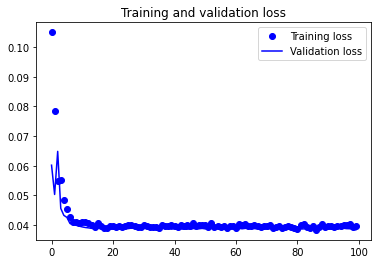

In [32]:
loss = running_loss_history
val_loss = val_running_loss_history

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("plot/train-valid-loss-resnet-50.jpg")
plt.show()

# **Model Validation**


**Validation on resnet 50**


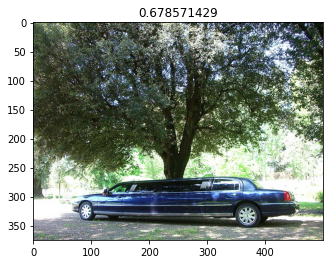

In [33]:
file = ""

def show_sample_from_dataset(i=0):
    global file

    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join(
        "images/"+str(dataset_validation.iloc[i]["image"]))
    file = image_path
    mem_val = os.path.join(
        str(dataset_validation.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_val)

show_sample_from_dataset()

In [34]:
image = None
from PIL import Image
def image_loader(loader, image_name):
    global image

    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)

    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print((resmodel_50(image_loader(data_transforms, file).double().to(device)).cpu().item()))

0.10959014065867456


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_45992/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_45992/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


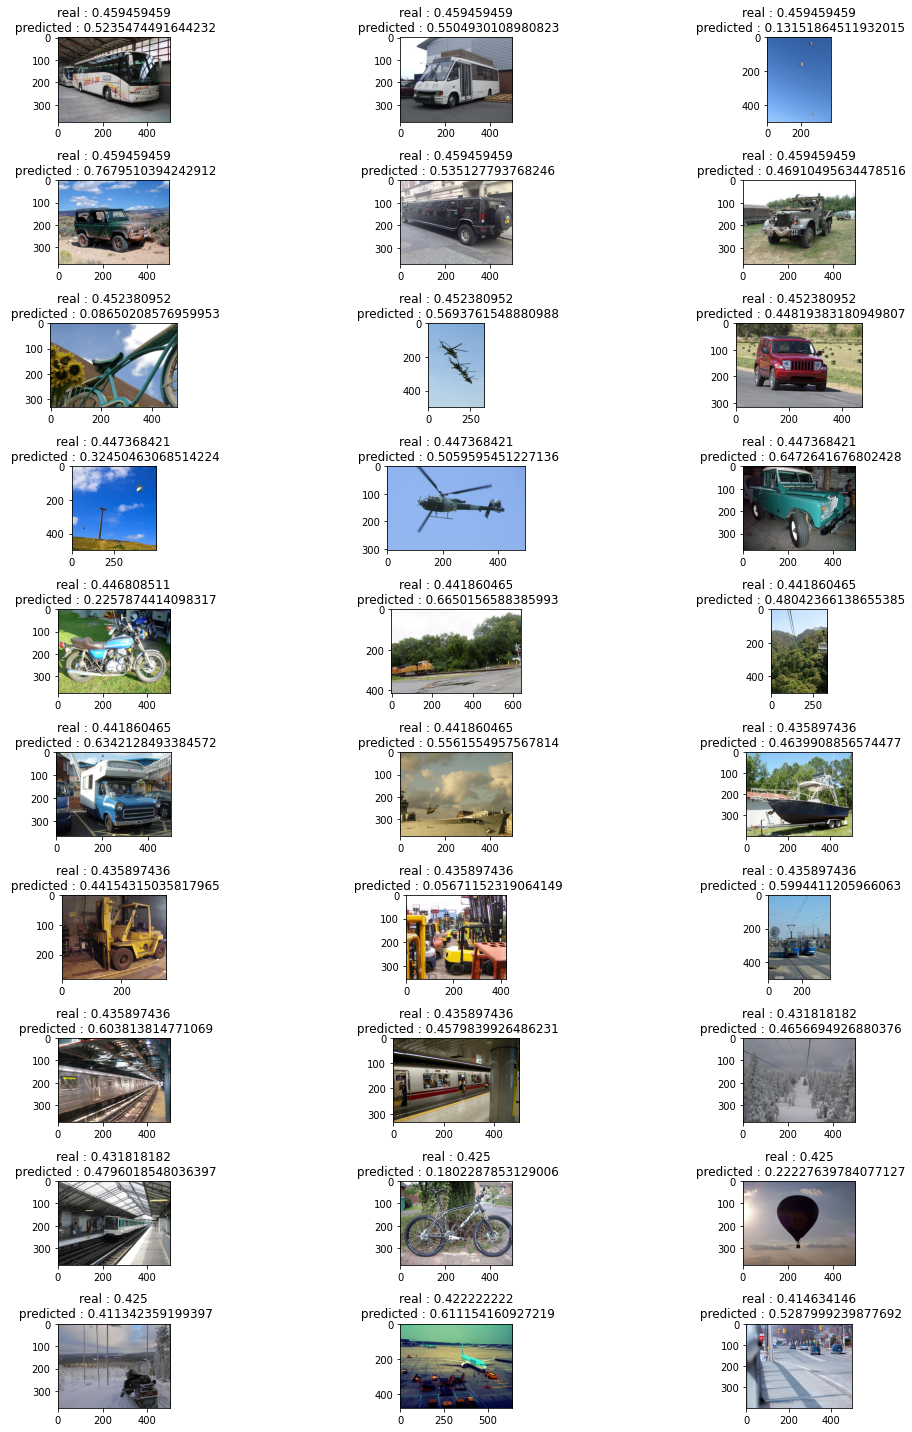

In [35]:
def show_grid(n_row, n_col):
    i = 100
    _, fig = plt.subplots(n_row, n_col, figsize=(20, 20))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join(
            "images/"+str(dataset_validation.iloc[i]["image"]))
        mem_val = os.path.join(
            str(dataset_validation.iloc[i]["memorability_score"]))
        pred = best_model_50(image_loader(
            data_transforms, image_path).double().to(device)).cpu().item()
        f.imshow(io.imread(image_path))
        plt.tight_layout()
        f.title.set_text("real : " + str(mem_val)+"\n predicted : "+str(pred))
        i = i+1

show_grid(10, 3)

In [36]:
best_model_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
running_loss_history

[0.10500120533996515,
 0.07831535485444828,
 0.054732205174778295,
 0.05515562231435077,
 0.048458695087902806,
 0.04549857024143481,
 0.042809016093955314,
 0.04101663661701625,
 0.041084458406631996,
 0.04076951342378499,
 0.041018611998063524,
 0.04094658573564181,
 0.04049781788149989,
 0.04015174955944489,
 0.039244532808271254,
 0.040570589079322275,
 0.03979528713462875,
 0.03904393903264724,
 0.03902589495874016,
 0.03958721222665337,
 0.03960404160472603,
 0.03923653362035505,
 0.03950962378102211,
 0.039251419816595357,
 0.0395159438426344,
 0.03993998689651565,
 0.03998920774258574,
 0.039645374047396334,
 0.03930623634331414,
 0.03918492493126679,
 0.0399066625470708,
 0.039664192955321774,
 0.039426927304467535,
 0.03929961889305083,
 0.03920512792539764,
 0.03910866634727054,
 0.040107897005141856,
 0.03956478829680537,
 0.0396761269124482,
 0.040061688989076874,
 0.03981093217181845,
 0.039361248161514525,
 0.039935005158123905,
 0.0397188932756071,
 0.040086719470974995

In [38]:
val_running_loss_history

[0.06016265091655963,
 0.05029428994336596,
 0.06482025616339084,
 0.04559361409189645,
 0.04324310390388597,
 0.04255532980602687,
 0.040495721926369445,
 0.04024091288483003,
 0.03988905242907312,
 0.0395996132426281,
 0.039346700860161225,
 0.0391461956903992,
 0.03902666353906346,
 0.03886562723583081,
 0.03872963163260621,
 0.03891841215046056,
 0.03912326652056434,
 0.0390637256994267,
 0.03876338936247664,
 0.03866467558352323,
 0.03865700422385864,
 0.03871179400850369,
 0.038765677172924735,
 0.038967639045193736,
 0.038969115904598395,
 0.03877799292818528,
 0.03895349581172935,
 0.038963952868657996,
 0.03870506547259622,
 0.03863133364675404,
 0.03884696669252773,
 0.038872352826784806,
 0.038777425299697355,
 0.03881106482965658,
 0.03885126543556518,
 0.038809215616847643,
 0.038980340795255294,
 0.038788555945114996,
 0.03877200556813875,
 0.03858208381665726,
 0.038733483009218,
 0.03850989514770196,
 0.03864029349824435,
 0.03860105898800243,
 0.03855422343457049,
 0.0

In [ ]:
predictions = []

for index, row in dataset_validation.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = best_model_50(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "validation"

    })

for index, row in dataset_train.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = best_model_50(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "train"

    })

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_45992/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


In [ ]:
image_list = []
real_list = []
prediction_list = []
image_type_list = []
for p in predictions:
    image_list.append(p["image"])
    real_list.append(p["real"])
    prediction_list.append(p["prediction"])
    image_type_list.append(p["tpye"])

dataframe_dict = {"image": image_list, "real": real_list,
                  "prediction": prediction_list, "tpye": image_type_list}

df = pd.DataFrame(dataframe_dict)

df.to_csv('csv/predictions_resnet50.csv')